In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from samplers import (
    DiscreteGaussianDataset, 
    DiscreteUniformDataset,
)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from utils import LoaderSampler
from light_sb_d import LightSB_D
from utils import fig2img, plot_samples

from types import SimpleNamespace 
import os
from prior import Prior
from benchmark import BenchmarkDiscreteEOT



In [6]:
# Prior parameters
NUM_CATEGORIES = 100
PRIOR_TYPE     = 'gaussian_log' 
ALPHA          = 0.02
NUM_TIMESTEPS  = 16
NUM_SKIP_STEPS = 8

#LightSB_D parameters
DIM            = 2
NUM_POTENTIALS = 4
DISTR_INIT     = 'benchmark_gaussian'

#Dataset parameters
FULL_SIZE      = 100000
BATCH_SIZE     = 512
SOURCE_DIST    = 'gaussian'

prior_params = dict(num_categories = NUM_CATEGORIES,
                    prior_type     = PRIOR_TYPE, 
                    alpha          = ALPHA,
                    num_timesteps  = NUM_TIMESTEPS,
                    num_skip_steps = NUM_SKIP_STEPS
                   )

solver_params = dict(dim            = DIM,
                     num_potentials = NUM_POTENTIALS,
                     distr_init     = DISTR_INIT,
                     )

dataset_params = dict(dim            = DIM,
                      num_categories = NUM_CATEGORIES,
                      full_size      = FULL_SIZE,
                      batch_size     = BATCH_SIZE,
                      source_dist    = SOURCE_DIST,
                      )


In [15]:
bench = BenchmarkDiscreteEOT(prior_params, solver_params, dataset_params, device='cuda:0', save_path='../../benchmark_data')

Computing benchmark...
Sampling target points...


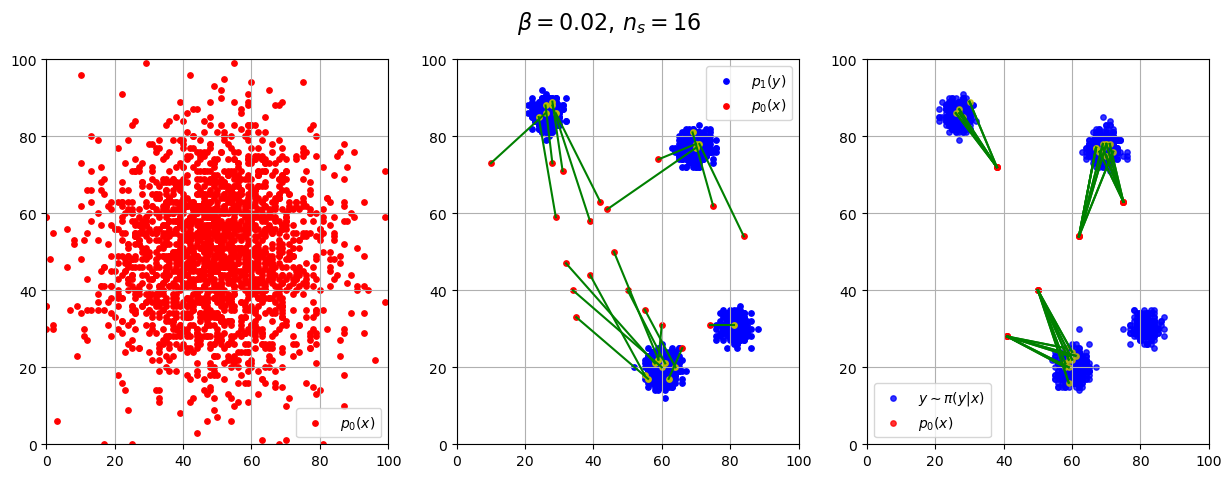

In [16]:
X0_test = bench.sample_input(2048)
X1_test = bench.sample_target(2048)
indices_plot = torch.randint(0, len(X0_test), (20,))


plot_samples(X0_test, X1_test, bench.D, indices_plot, ALPHA, NUM_TIMESTEPS, xrange=[0, 100], yrange=[0, 100], plot_trajectories=True, by_dims=False, index_0=2, index_1=3)
plt.show()

In [17]:
bench.save()

Saving benchmark...


In [20]:
DIMS              = [64]#, 16, 64]
NUM_CATEGORIES    = [100]#, 200] #It has to be big enough to get benchmark samples
NUM_POTENTIALS    = 4
DEVICE            = 'cpu'
#PRIOR_TYPES       = ['gaussian_log', 'uniform']
SOURCE_DIST       = 'gaussian'
BENCHMARK_SIZE    = 100000
NUM_STEPS         = 16 #16
NUM_SKIP_STEPS    = 8 #8
PRIOR_TYPES_BETAS = {'uniform':[0.02]}#, 'uniform':[0.01, 0.005]}
  
config = dict(DIMS              = DIMS,
              NUM_CATEGORIES    = NUM_CATEGORIES,
              N_POTENTIALS      = NUM_POTENTIALS,
              PRIOR_TYPES_BETAS = PRIOR_TYPES_BETAS, 
              NUM_STEPS         = NUM_STEPS,
              NUM_SKIP_STEPS    = NUM_SKIP_STEPS
              )


torch.Size([100, 64])


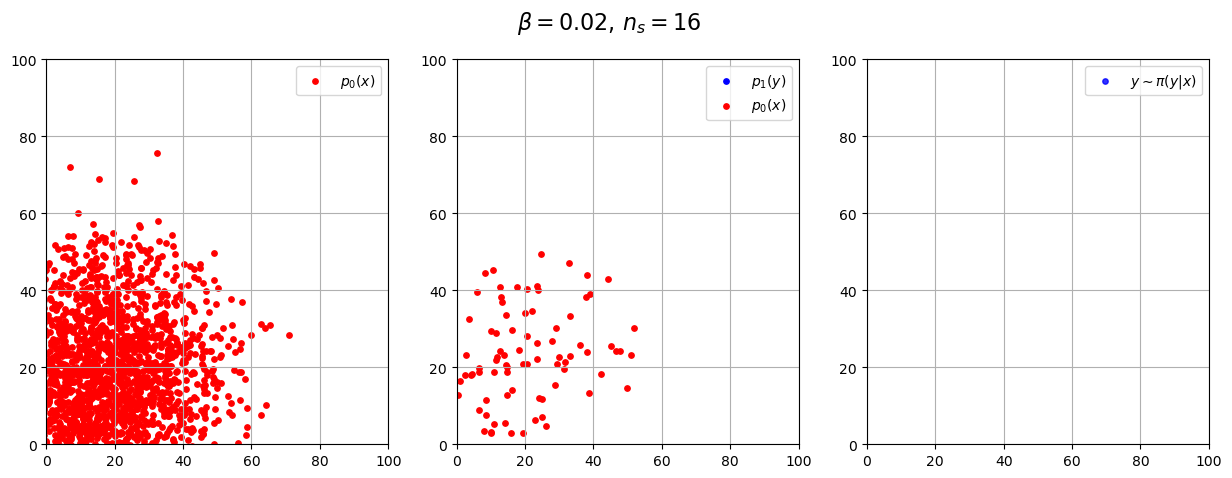

In [21]:
import itertools

dims_cats_combs = list(itertools.product(DIMS, NUM_CATEGORIES))
prior_beta_list = [(key, value) for key in PRIOR_TYPES_BETAS for value in PRIOR_TYPES_BETAS[key]]

save_path = None#'../benchmark_data'

for dim_cat in dims_cats_combs:
    DIM          = dim_cat[0]
    NUM_CATEGORY = dim_cat[1]
    
    if SOURCE_DIST == 'gaussian':
        X0_full = DiscreteGaussianDataset(num_samples=BENCHMARK_SIZE, dim=DIM, num_categories=NUM_CATEGORY, 
                                         train=True).dataset.to(DEVICE)
    if SOURCE_DIST == 'uniform':
        X0_full = DiscreteUniformDataset(num_samples=BENCHMARK_SIZE, dim=DIM, num_categories=NUM_CATEGORY, 
                                         train=True).dataset.to(DEVICE)

    if save_path is not None:
        torch.save(X0_full, os.path.join(save_path, f'X0_benchmark_dim_{DIM}_P0_{SOURCE_DIST}_num_categories_{NUM_CATEGORY}.pt'))

    for prior_beta in prior_beta_list:
        PRIOR_TYPE = prior_beta[0]
        BETA       = prior_beta[1]
            
        prior = Prior(BETA, NUM_CATEGORY, NUM_STEPS, NUM_SKIP_STEPS, PRIOR_TYPE)
        #print(X0_full)
        bench = BenchmarkDiscreteEOT(SOURCE_DIST, DIM, prior, num_potentials=NUM_POTENTIALS, compute_benchmark=True, X0_full=X0_full, save_path=save_path, device=DEVICE)
        N_SAMPLES  = 2000
        X0_samples = bench.sample_X0(N_SAMPLES)
        X1_samples = bench.sample_X1(N_SAMPLES)
        indices_plot = torch.arange(0, N_SAMPLES)[:100]
        plot_samples(X0_samples, X1_samples, bench.D, indices_plot, BETA, NUM_STEPS, xrange=[0, 100], yrange=[0, 100], plot_trajectories=False);
        #assert False

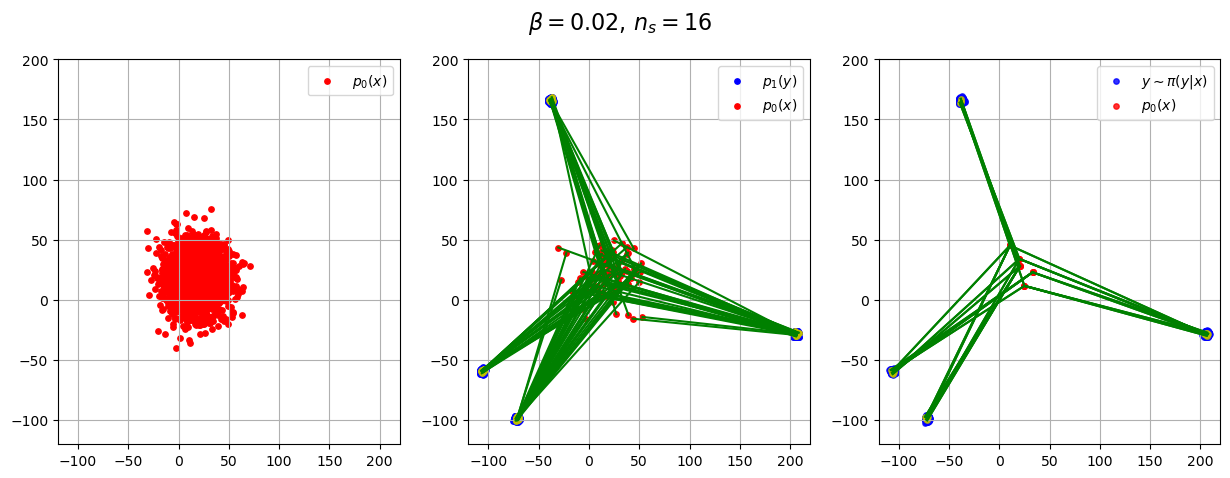

In [27]:
plot_samples(X0_samples, X1_samples, bench.D, indices_plot, BETA, NUM_STEPS, xrange=[-120, 220], yrange=[-120, 200], plot_trajectories=True);


In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Parameters
D = 3             # dimensionality
n_bins = 100       # discrete values per axis
K = 4             # number of Gaussians in the mixture

# Create grid of discrete coordinates
grid = torch.arange(n_bins)
mesh = torch.meshgrid([grid for _ in range(D)], indexing='ij')
coords = torch.stack([m.flatten() for m in mesh], dim=-1).float()  # shape: (n_bins**D, D)

# Sample random Gaussian parameters
torch.manual_seed(42)
means = torch.randint(5, n_bins-5, (K, D)).float()
covs = torch.stack([torch.diag(torch.rand(D) * 10 + 5) for _ in range(K)])  # moderate spread
weights = torch.ones(K) / K  # uniform weights

# Evaluate each Gaussian on the grid
pdfs = []
for k in range(K):
    dist = MultivariateNormal(loc=means[k], covariance_matrix=covs[k])
    log_prob = dist.log_prob(coords)  # (n_bins**D,)
    pdfs.append(torch.exp(log_prob) * weights[k])

# Combine the mixture
full_prob = torch.stack(pdfs, dim=0).sum(dim=0)
prob_tensor = full_prob.reshape([n_bins] * D)
prob_tensor /= prob_tensor.sum()  # normalize

# Visualization (thresholded 3D scatter)
threshold = 0.0005  # show only high-probability mass

x, y, z = torch.where(prob_tensor > threshold)
probs = prob_tensor[x, y, z]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x.numpy(), y.numpy(), z.numpy(), c=probs.log().numpy(), cmap='viridis', s=20)
plt.colorbar(sc, label='log-probability')
ax.set_title("3D Discrete Mixture of Gaussians")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Parameters
D = 3
K = 4                 # number of components
n_samples = 10000     # total number of points

np.random.seed(42)

# Define Gaussian mixture parameters
means = np.random.uniform(0, 10, size=(K, D))
covs = np.array([np.diag(np.random.uniform(0.5, 1.5, size=D)) for _ in range(K)])
weights = np.random.dirichlet(np.ones(K))

# Sample from mixture
samples = []
for i in range(K):
    n_k = int(weights[i] * n_samples)
    samples.append(np.random.multivariate_normal(mean=means[i], cov=covs[i], size=n_k))
samples = np.concatenate(samples, axis=0)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=0.3, s=5, c='steelblue')
ax.set_title("3D Mixture of Gaussians")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


In [ ]:
class 